In [1]:
import jupedsim as jps
import pedpy
from shapely import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pathlib
from dataclasses import dataclass, field
from typing import List, Tuple, Optional
from enum import Enum

In [2]:
class AreaType(Enum):
    """Enumeration for different types of areas."""

    CORRIDOR_SHORT = "corridor_short"
    CORRIDOR_LONG = "corridor_long"
    CORNER = "corner"


@dataclass
class Scenario:
    """
    A class representing a simulation scenario.

    Attributes:
        type (AreaType): The type of area for the scenario.
        area (Polygon): The polygon defining the main area of the scenario.
        exit (Polygon): The polygon defining the exit area.
        positions (List[Tuple[float, float]]): List of positions (x, y) for agents.
        waypoints (List[Tuple[float, float]]): List of waypoints for agents' paths.
        distance_to_waypoints (int): Distance to waypoints from agents.

    Auto-initialized Attributes:
        journey_description (jps.JourneyDescription): Description of the journey for the simulation.
        waypoint_ids (List[int]): List of IDs for each waypoint in the simulation.
        walkable_area (pedpy.WalkableArea): Walkable area derived from the main area.
        trajectory_file (str): File path for storing the simulation trajectory.
        simulation (jps.Simulation): The JPS simulation object.
    """

    type: AreaType
    area: Polygon
    exit: Polygon

    positions: List[Tuple[float, float]]
    waypoints: List[Tuple[float, float]] = field(default_factory=list)
    seed: int = 1
    distance_to_waypoints: int = 5
    # ------------------------------------------
    journey_description: jps.JourneyDescription = field(init=False)
    waypoint_ids: List[int] = field(init=False, default_factory=list)
    walkable_area: pedpy.WalkableArea = field(init=False)
    trajectory_file: str = field(init=False)
    simulation: jps.Simulation = field(init=False)

    def __post_init__(self):
        """Initializes the simulation and related components after dataclass initialization."""
        self.trajectory_file = f"traj_scenario_{self.type.name}_{self.seed}.sqlite"
        self.walkable_area = pedpy.WalkableArea(self.area)
        self.simulation = self.create_simulation()
        self.journey_description, self.waypoint_ids = self.create_journey()
        self.init_agents()

    def create_journey(self) -> jps.JourneyDescription:
        """
        Creates a journey description for the scenario.

        Returns:
            jps.JourneyDescription: The journey description for the simulation.
        """
        exit_id = self.simulation.add_exit_stage(self.exit)
        waypoint_ids = (
            [
                self.simulation.add_waypoint_stage(waypoint, self.distance_to_waypoints)
                for waypoint in self.waypoints
            ]
            if self.waypoints
            else [exit_id]
        )

        journey = jps.JourneyDescription([*waypoint_ids, exit_id])
        # from all waypoints ---> exit
        for waypoint_id in waypoint_ids:
            journey.set_transition_for_stage(
                waypoint_id, jps.Transition.create_fixed_transition(exit_id)
            )

        return journey, waypoint_ids

    def create_simulation(self) -> jps.Simulation:
        """
        Creates the simulation object for the scenario.

        Returns:
            jps.Simulation: The simulation object initialized for the scenario.
        """
        return jps.Simulation(
            model=jps.CollisionFreeSpeedModel(),
            dt=0.01,
            geometry=self.area,
            trajectory_writer=jps.SqliteTrajectoryWriter(
                output_file=pathlib.Path(self.trajectory_file)
            ),
        )

    def init_agents(self):
        """
        Initializes agents in the simulation based on positions and waypoints.
        """
        journey_id = self.simulation.add_journey(self.journey_description)
        if self.waypoints:
            stage_ids = [
                self.waypoint_ids[i % len(self.waypoints)]
                for i in range(len(self.positions))
            ]
        else:
            # If no waypoints, use a default stage ID for all agents
            default_stage_id = self.waypoint_ids[0]
            stage_ids = [default_stage_id] * len(self.positions)

        for pos, stage_id in zip(self.positions, stage_ids):
            self.simulation.add_agent(
                jps.CollisionFreeSpeedModelAgentParameters(
                    journey_id=journey_id,
                    stage_id=stage_id,
                    position=pos,
                )
            )

    def run_simulation(self):
        """
        Runs the simulation until all agents have exited or the simulation reaches its limit.

        Returns:
            float: The total time taken for the simulation in seconds.
        """
        print(f"run simulation {self.type.name} with {self.simulation.agent_count()}")
        while self.simulation.agent_count() > 0:
            self.simulation.iterate()

        evac_time = self.simulation.iteration_count() * self.simulation.delta_time()
        print(f">> evac time: {evac_time:.2f} seconds.")
        return evac_time

## Scenario: Corridor short


In [3]:
corridor_short_area = Polygon(
    [[0, 0], [20, 0], [20, -(6 + 44 + 6)], [0, -(6 + 44 + 6)]]
)
corridor_short_exit = Polygon(
    [
        [0, -(6 + 44)],
        [20, -(6 + 44)],
        [20, -(6 + 44 + 6)],
        [0, -(6 + 44 + 6)],
    ]
)

## Scenario corner


In [4]:
corner_area = Polygon(
    [
        [0, 0],
        [20, 0],
        [20, -(34 + 6)],
        [30 + 6, -(34 + 6)],
        [30 + 6, -(20 + 34 + 6)],
        [0, -(20 + 34 + 6)],
    ]
)
corner_exit = Polygon(
    [[30, -(34 + 6)], [36, -(34 + 6)], [36, -(34 + 6 + 20)], [30, -(34 + 6 + 20)]]
)
corner_waypoints = [
    (15, -40),
    (10, -45),
    (5, -50),
]

## Scenario: Corridor long


In [5]:
corridor_long_area = Polygon(
    [[0, 0], [20, 0], [20, -(6 + 75.4 + 6)], [0, -(6 + 75.4 + 6)]]
)

corridor_long_exit = Polygon(
    [
        [0, -(6 + 75.4)],
        [20, -(6 + 75.4)],
        [20, -(6 + 75.4 + 6)],
        [0, -(6 + 75.4 + 6)],
    ]
)

In [6]:
scenario_details = {
    AreaType.CORRIDOR_SHORT: {
        "area": corridor_short_area,
        "exit": corridor_short_exit,
        "waypoints": [],
        "distance_to_waypoints": 0,
    },
    AreaType.CORNER: {
        "area": corner_area,
        "exit": corner_exit,
        "waypoints": corner_waypoints,
        "distance_to_waypoints": 5,
    },
    AreaType.CORRIDOR_LONG: {
        "area": corridor_long_area,
        "exit": corridor_long_exit,
        "waypoints": [],
        "distance_to_waypoints": 0,
    },
}
spawning_area = Polygon([[0, 0], [20, 0], [20, -7], [0, -7]])

## Visual check


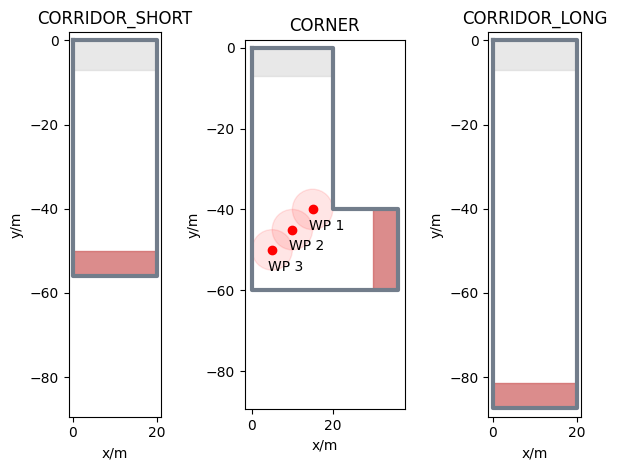

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=1)

for ax, (scenario_type, details) in zip(axes, scenario_details.items()):
    pedpy.plot_walkable_area(
        walkable_area=pedpy.WalkableArea(details["area"]), line_width=3, axes=ax
    ).set_aspect("equal")
    ax.fill(
        *spawning_area.exterior.xy, color="lightgrey", alpha=0.5, label="Spawning Area"
    )
    ax.fill(*details["exit"].exterior.xy, color="indianred", alpha=0.7, label="Exit")

    ax.set_ylim([-(6 + 75.4 + 6 + 2), 2])
    for idx, waypoint in enumerate(details["waypoints"]):
        ax.plot(waypoint[0], waypoint[1], "ro")
        ax.annotate(
            f"WP {idx+1}",
            (waypoint[0], waypoint[1]),
            textcoords="offset points",
            xytext=(10, -15),
            ha="center",
        )
        circle = Circle(
            (waypoint[0], waypoint[1]),
            details["distance_to_waypoints"],
            fc="red",
            ec="red",
            alpha=0.1,
        )
        ax.add_patch(circle)
    ax.set_title(scenario_type.name)

plt.tight_layout()

## Run simulations


In [8]:
import random
num_agents = 10
evac_times = {}
num_reps = 3
for scenario_type, details in scenario_details.items():
    evac_times[scenario_type.name] = []

    for _ in range(num_reps):
        seed = random.randint(1, 10000)
        positions = jps.distributions.distribute_by_number(
            polygon=spawning_area,
            number_of_agents=num_agents,
            distance_to_agents=0.4,
            distance_to_polygon=0.3,
            seed=seed,
        )
        s = Scenario(
            type=scenario_type,
            area=details["area"],
            exit=details["exit"],
            positions=positions,
            waypoints=details["waypoints"],
            seed=seed,
        )
        evac_time = s.run_simulation()
        evac_times[scenario_type.name].append(evac_time)

run simulation CORRIDOR_SHORT with 10
>> evac time: 41.97 seconds.
run simulation CORRIDOR_SHORT with 10
>> evac time: 40.86 seconds.
run simulation CORRIDOR_SHORT with 10
>> evac time: 42.03 seconds.
run simulation CORNER with 10
>> evac time: 57.95 seconds.
run simulation CORNER with 10
>> evac time: 58.02 seconds.
run simulation CORNER with 10
>> evac time: 58.12 seconds.
run simulation CORRIDOR_LONG with 10
>> evac time: 67.93 seconds.
run simulation CORRIDOR_LONG with 10
>> evac time: 67.44 seconds.
run simulation CORRIDOR_LONG with 10
>> evac time: 67.57 seconds.


## Plot results

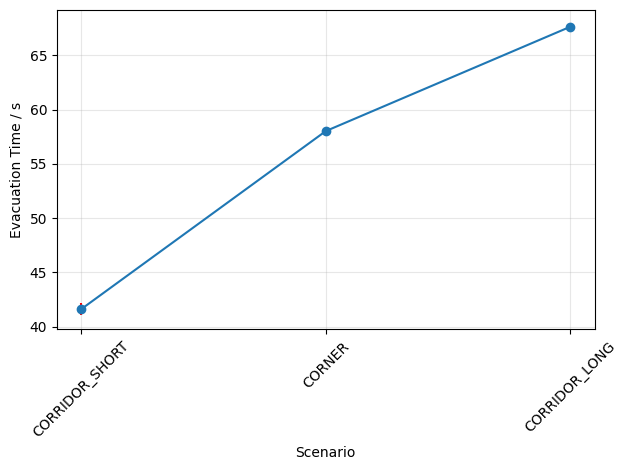

In [9]:
import numpy as np

mean_evac_times = {scenario: np.mean(times) for scenario, times in evac_times.items()}
std_dev_evac_times = {scenario: np.std(times) for scenario, times in evac_times.items()}

scenario_names = [scenario.name for scenario in scenario_details.keys()]
means = [mean_evac_times[scenario.name] for scenario in scenario_details.keys()]
std_devs = [std_dev_evac_times[scenario.name] for scenario in scenario_details.keys()]

plt.errorbar(scenario_names, means, yerr=std_devs, fmt="o-", ecolor="red")

plt.xlabel("Scenario")
plt.ylabel("Evacuation Time / s")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()